In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         48 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               AuthenticAMD
  Model name:            AMD Ryzen 7 PRO 8840U w/ Radeon 780M Graphics
    CPU family:          25
    Model:               117
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            2
    BogoMIPS:            6587.65
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n
                         x mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_go
                         od nopl tsc_reliable nonstop_tsc cpuid extd_apicid pni 
                         pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes
                          xsave avx f16c rdrand hypervisor l

In [2]:
# ==================== Importing Libraries ====================
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import sys
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import norm, truncnorm, beta
from scipy.signal import fftconvolve
from scipy.integrate import quad
from bisect import bisect_left
from tqdm import tqdm

In [3]:
# 全ての環境に通じるグローバルなパラメータの定義

# 最小時間間隔
# ※ ここを 1 より大きくすると、最小到着間隔が最小時間単位より小さくなるような状況が起きるので NG
MINIMUM_TIME_UNIT = 0.001 # (1 = 1ms として定義)

# 実数の時間を最小時間単位に合わせて切り上げる関数
def round_min_unit(time):
    return math.ceil(time / MINIMUM_TIME_UNIT) * MINIMUM_TIME_UNIT

ABNORMAL_MODE_PROB = 0.05  # 異常モードの確率
NORMAL_MEAN_COEFF = 3.0    # 正常時の平均を WCET の 1 / 何倍にするか
NORMAL_STD_COEFF = 10.0    # 正常時の標準偏差を WCET の 1 / 何倍にするか
ABNORMAL_MEAN_COEFF = 1.2  # 異常時の平均を WCET の 1 / 何倍にするか
ABNORMAL_STD_COEFF = 30.0  # 異常時の標準偏差を WCET の 1 / 何倍にするか

# ==================== 実行時間分布の期待値等の諸計算関数 ==================== #

def get_truncated_normal(mu, sigma, lower_bound, upper_bound):
    a, b = (lower_bound - mu) / sigma, (upper_bound - mu) / sigma
    return truncnorm(a, b, loc=mu, scale=sigma)

def calculate_truncated_mean(mu, sigma, lower_bound, upper_bound):
    a, b = (lower_bound - mu) / sigma, (upper_bound - mu) / sigma
    return truncnorm.mean(a, b, loc=mu, scale=sigma)

def calculate_expected_execution_time(wcet, trunc_lower, trunc_upper):
    range_size = (trunc_upper - trunc_lower) / MINIMUM_TIME_UNIT
    if range_size <= 30:  # 実行時間分布がスカスカになる場合
        # MINIMUM_TIME_UNIT ごとに離散化
        discrete_times = np.arange(trunc_lower, trunc_upper + MINIMUM_TIME_UNIT, MINIMUM_TIME_UNIT)
        expected_execution_time = 0.0

        # 確率密度関数を for 文で直接計算
        for t in discrete_times:
            probability = (
                (1 - ABNORMAL_MODE_PROB) * get_truncated_normal(wcet / NORMAL_MEAN_COEFF, wcet / NORMAL_STD_COEFF, 0, wcet).pdf(t) +
                ABNORMAL_MODE_PROB * get_truncated_normal(wcet / ABNORMAL_MEAN_COEFF, wcet / ABNORMAL_STD_COEFF, 0, wcet).pdf(t)
            )
            # 確率 × 実行時間の幅（MINIMUM_TIME_UNIT）で期待値に加算
            expected_execution_time += probability * MINIMUM_TIME_UNIT * t
    else: # 範囲が広い場合、従来通り正規分布と近似して算出
        normal_mu = wcet / NORMAL_MEAN_COEFF
        normal_sigma = wcet / NORMAL_STD_COEFF
        abnormal_mu = wcet / ABNORMAL_MEAN_COEFF
        abnormal_sigma = wcet / ABNORMAL_STD_COEFF
        normal_truncated_mean = calculate_truncated_mean(normal_mu, normal_sigma, trunc_lower, trunc_upper)
        abnormal_truncated_mean = calculate_truncated_mean(abnormal_mu, abnormal_sigma, trunc_lower, trunc_upper)
        expected_execution_time = (1 - ABNORMAL_MODE_PROB) * normal_truncated_mean + ABNORMAL_MODE_PROB * abnormal_truncated_mean
    return expected_execution_time

def calculate_wcet(minimum_inter_arrival_time, rate, tol=1e-10):
    low, high = 0, minimum_inter_arrival_time
    target = minimum_inter_arrival_time * rate
    while high - low > tol:
        mid = (low + high) / 2.0
        expected_time = calculate_expected_execution_time(mid, 0, mid)
        if expected_time < target:
            low = mid
        else:
            high = mid
    return (low + high) / 2.0


In [4]:
class Job:
    _id_counter = 0  # クラス変数としてIDカウンタを保持

    def __init__(self, task, release_time):
        self.task = task                                               # task オブジェクトを参照
        self.release_time = release_time                               # リリース時間
        self.absolute_deadline = release_time + task.relative_deadline # 絶対デッドラインを計算
        self.id = self.get_id()                                        # 一意なIDを割り当てる

    # ID生成用の関数
    @classmethod
    def get_id(cls):
        cls._id_counter += 1
        return cls._id_counter

    # レートモノトニックスケジューリングの優先度比較用
    def __lt__(self, other):
        # 1. 最小到着間隔が大きい方が優先度が低い
        if self.task.minimum_inter_arrival_time != other.task.minimum_inter_arrival_time:
            return other.task.minimum_inter_arrival_time < self.task.minimum_inter_arrival_time
        # 2. 最小到着間隔が同じ場合は絶対デッドラインが大きい方が優先度が低い
        return other.absolute_deadline < self.absolute_deadline

    # 同一タスクからリリースされるジョブか否かの判定用
    def __eq__(self, other):
        return self.task == other.task


In [5]:
class Task:
    def __init__(self, wcet, relative_deadline, minimum_inter_arrival_time, theta=0.5):
        # 時間関連の引数を最小単位時間に合わせて切り上げ
        self.wcet = round_min_unit(wcet)
        self.relative_deadline = relative_deadline
        self.minimum_inter_arrival_time = round_min_unit(minimum_inter_arrival_time)
        self.theta = theta

        # 正常時と異常時の分布
        self.normal_mu = self.wcet / NORMAL_MEAN_COEFF
        self.normal_sigma = self.wcet / NORMAL_STD_COEFF
        self.normal_dist = get_truncated_normal(mu=self.normal_mu, sigma=self.normal_sigma, lower_bound=0, upper_bound=self.wcet)
        self.abnormal_mu = self.wcet / ABNORMAL_MEAN_COEFF
        self.abnormal_sigma = self.wcet / ABNORMAL_STD_COEFF
        self.abnormal_dist = get_truncated_normal(mu=self.abnormal_mu, sigma=self.abnormal_sigma, lower_bound=0, upper_bound=self.wcet)

        # 累積分布関数 (CDF) を計算
        self.create_cdf(theta)
    
    def create_cdf(self, theta):
        # min_value を 0, max_value を self.wcet に設定
        min_value = 0
        max_value = self.wcet
        theta /= self.wcet  # θ を正規化
    
        # x_values を MINIMUM_TIME_UNIT レベルで生成
        adjusted_min_value = max(MINIMUM_TIME_UNIT, np.ceil(min_value / MINIMUM_TIME_UNIT) * MINIMUM_TIME_UNIT)
        adjusted_max_value = np.floor(max_value / MINIMUM_TIME_UNIT) * MINIMUM_TIME_UNIT
        self.x_values = np.arange(adjusted_min_value, adjusted_max_value + MINIMUM_TIME_UNIT, MINIMUM_TIME_UNIT)
        if self.x_values[0] != 0:
            self.x_values = np.insert(self.x_values, 0, 0.0)
    
        # PDF を計算
        normal_pdf_values = (1 - ABNORMAL_MODE_PROB) * self.normal_dist.pdf(self.x_values)
        abnormal_pdf_values = ABNORMAL_MODE_PROB * self.abnormal_dist.pdf(self.x_values)
        self.original_pdf_values = normal_pdf_values + abnormal_pdf_values
        self.original_pdf_values[0] = 0.0 # 0 の確率を 0 に設定
    
        # 台形則で元の PDF の面積を計算して正規化
        normalization_constant_original = np.trapezoid(self.original_pdf_values, self.x_values)
        self.original_pdf_values /= normalization_constant_original
    
        # 元の CDF を計算
        self.cdf_values = np.cumsum(self.original_pdf_values)
        self.cdf_values /= self.cdf_values[-1]  # 最後が 1 になるように正規化
    
        # 対数空間で計算
        epsilon = 1e-10
        log_original_pdf_values = np.log(np.maximum(self.original_pdf_values, epsilon))
        log_tilted_pdf_values = log_original_pdf_values + theta * self.x_values
        self.tilted_pdf_values = np.exp(log_tilted_pdf_values)
    
        # 台形則で傾斜後 PDF の面積を計算して正規化
        normalization_constant_tilted = np.trapezoid(self.tilted_pdf_values, self.x_values)
        self.tilted_pdf_values /= normalization_constant_tilted
    
        # 傾斜後の CDF を計算
        self.tilted_cdf_values = np.cumsum(self.tilted_pdf_values)
        self.tilted_cdf_values /= self.tilted_cdf_values[-1]  # 最後が 1 になるように正規化

    def get_execution_time(self):
        # CDF(x) >= Y となる x を二分探索して x_values を return (逆変換 sampling)
        random_value = np.random.uniform(0, 1)
        idx = bisect_left(self.cdf_values, random_value)
        return self.x_values[idx]
    
    def get_execution_time_with_weight(self):
        # ランダムな値を生成して逆変換サンプリング
        random_value = np.random.uniform(0, 1)
        idx = bisect_left(self.tilted_cdf_values, random_value)
        sampled_execution_time = self.x_values[idx]

        # 元の PDF と傾斜後の PDF の値を取得
        original_pdf = self.original_pdf_values[idx]
        tilted_pdf = self.tilted_pdf_values[idx]

        # 重みを計算
        weight = original_pdf / tilted_pdf
        return sampled_execution_time, weight

    def get_log_pWCET_mgf(self, s):
        upper_bound = self.abnormal_mu + 5 * self.abnormal_sigma # 積分範囲を設定 (異常時の期待値 + 5σ まで)
        a = s * upper_bound # Log-Sum-Expトリックでの最大項 a を計算

        # 対数 MGF の計算
        def log_integrand(x):
            # 正常時と異常時の分布の加重平均として PDF を計算
            pdf_value = (1 - ABNORMAL_MODE_PROB) * self.normal_dist.pdf(x) + ABNORMAL_MODE_PROB * self.abnormal_dist.pdf(x)
            return (s * x - a) + np.log(pdf_value)  # 対数空間で計算し、最大項aを引く

        # 積分の結果を計算し、log_sum_expを戻す
        log_pWCET_mgf, _ = quad(lambda x: np.exp(log_integrand(x)), 0, upper_bound)
        return a + np.log(log_pWCET_mgf)


In [6]:
class Taskset:
    def __init__(self, task_num, utilization_rate, seed=0):
        self.task_num = task_num
        self.utilization_rate = utilization_rate
        self.seed = seed
        np.random.seed(self.seed)
        random.seed(self.seed)

        # タスクリスト、タイムライン、到着時間リストの初期化
        self.tasks = []
        self.timeline = []
        self.arrival_times = []

        # タスクセットの生成
        self.generate_task_set()

        # タイムラインからジョブが存在する時刻を取得
        for t, jobs_at_t in enumerate(self.timeline):
            if jobs_at_t:
                # 優先度が高い順にソート
                jobs_at_t.sort(reverse=True)
                self.arrival_times.append(t)

    def generate_task_set(self):
        dirichlet_dist = np.random.dirichlet(np.ones(self.task_num))
        execution_rates = dirichlet_dist * self.utilization_rate

        # タスクの影響力計算用リスト
        task_influences = []

        max_deadline = 0

        # 各タスクの周期、影響力を計算
        for rate in execution_rates:
            # タスク周期をランダムに選択
            minimum_inter_arrival_time = int(np.exp(np.random.uniform(np.log(10), np.log(1000))) / MINIMUM_TIME_UNIT) * MINIMUM_TIME_UNIT

            # 相対デッドライン（今回は周期と同じ値）
            relative_deadline = minimum_inter_arrival_time
            max_deadline = max(max_deadline, relative_deadline)

            # WCET を計算
            wcet = calculate_wcet(minimum_inter_arrival_time, rate)

            # 影響力を計算: T * u = 最小間隔 × 利用率
            influence = minimum_inter_arrival_time * rate
            task_influences.append((wcet, relative_deadline, minimum_inter_arrival_time, rate, influence))

        # 影響力が大きい順にソート
        task_influences.sort(key=lambda x: x[-1], reverse=True)  # 影響力 (influence) を基準に降順ソート

        # 上位 5 タスクは θ = 1.0、それ以外は θ = 0.0 で Task を生成
        for i, (wcet, relative_deadline, minimum_inter_arrival_time, rate, influence) in enumerate(task_influences):
            theta = 1.0 if i < self.task_num * 0.30 else 0.0  # 上位 5 タスクは θ = 1.0、それ以外は θ = 0.0

            task = Task(
                wcet=wcet,
                relative_deadline=relative_deadline,
                minimum_inter_arrival_time=minimum_inter_arrival_time,
                theta=theta  # θ を Task クラスに渡す
            )
            self.tasks.append(task)
        # task の周期が短い順にソート (レートモノトニック)
        self.tasks.sort(key=lambda x: x.minimum_inter_arrival_time)

        # タイムラインの設定
        timeline_size = int((max_deadline + 1) / MINIMUM_TIME_UNIT)
        self.timeline = [[] for _ in range(timeline_size)]

        # タイムラインにタスクを追加
        for task in self.tasks:
            print(f"Task: T={task.minimum_inter_arrival_time}, u={task.wcet / task.minimum_inter_arrival_time:.2f}, θ={task.theta}")
            t = 0
            while t <= max_deadline:
                job = Job(task, t)
                timeline_index = int(t / MINIMUM_TIME_UNIT)
                self.timeline[timeline_index].append(job)
                t += task.minimum_inter_arrival_time


In [7]:
# ==================== テスト用タスクセットでの実行時間サンプル例 ==================== #
# test_task = Task(wcet=10, relative_deadline=10, minimum_inter_arrival_time=10, theta=2.0)

# # 1つ目のプロット: CDF
# plt.step(test_task.x_values, test_task.cdf_values, label="CDF", where='post', color='gray')
# plt.xlabel("Execution Time")
# plt.ylabel("Cumulative Distribution Function")
# plt.title("Step CDF")
# plt.legend()
# plt.grid()
# plt.show()

# # 2つ目のプロット: 逆変換サンプリング（元の分布）と指数傾斜サンプリング
# # 逆変換サンプリングでデータを取得
# sample_num = 10000
# original_samples = [test_task.get_execution_time() for _ in range(sample_num)]
# tilted_samples = [test_task.get_execution_time_with_weight()[0] for _ in range(sample_num)]

# # 元の分布に従うサンプルのヒストグラム
# bins = np.linspace(0, test_task.abnormal_mu + 3 * test_task.abnormal_sigma, 20)

# # サブプロットを使って分けてプロット
# fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# # 元の分布のサンプルと PDF
# axes[0].hist(original_samples, bins=bins, edgecolor='black', alpha=0.6, density=True, label="Original Sampling", color='pink')
# axes[0].plot(test_task.x_values, test_task.original_pdf_values, label="Original PDF", color='red', linestyle='--', linewidth=2)
# axes[0].plot(test_task.x_values, test_task.tilted_pdf_values, label="Tilted PDF", color='blue', linestyle='-', linewidth=2)
# axes[0].set_title("Original Sampling and PDF")
# axes[0].set_ylabel("Density")
# axes[0].legend()
# axes[0].grid()

# # 指数傾斜後のサンプルと PDF
# axes[1].hist(tilted_samples, bins=bins, edgecolor='black', alpha=0.6, density=True, label="Tilted Sampling", color='lightblue')
# axes[1].plot(test_task.x_values, test_task.original_pdf_values, label="Original PDF", color='red', linestyle='--', linewidth=2)
# axes[1].plot(test_task.x_values, test_task.tilted_pdf_values, label="Tilted PDF", color='blue', linestyle='-', linewidth=2)
# axes[1].set_title("Tilted Sampling and PDF")
# axes[1].set_xlabel("Execution Time")
# axes[1].set_ylabel("Density")
# axes[1].legend()
# axes[1].grid()

# # プロット表示
# plt.tight_layout()
# plt.show()


Task: T=12.33, u=0.02, θ=0.0
Task: T=12.537, u=0.01, θ=0.0
Task: T=12.92, u=0.01, θ=0.0
Task: T=13.045, u=0.05, θ=0.0
Task: T=13.321, u=0.01, θ=0.0
Task: T=13.469, u=0.01, θ=0.0
Task: T=13.812000000000001, u=0.01, θ=0.0
Task: T=14.036, u=0.02, θ=0.0
Task: T=14.062000000000001, u=0.05, θ=0.0
Task: T=14.646, u=0.07, θ=0.0
Task: T=15.121, u=0.00, θ=0.0
Task: T=15.284, u=0.01, θ=0.0
Task: T=15.528, u=0.00, θ=0.0
Task: T=19.007, u=0.01, θ=0.0
Task: T=19.349, u=0.02, θ=0.0
Task: T=20.299, u=0.00, θ=0.0
Task: T=20.536, u=0.01, θ=0.0
Task: T=20.704, u=0.01, θ=0.0
Task: T=21.88, u=0.01, θ=0.0
Task: T=22.616, u=0.01, θ=0.0
Task: T=24.218, u=0.02, θ=0.0
Task: T=25.696, u=0.02, θ=0.0
Task: T=26.226, u=0.01, θ=0.0
Task: T=27.033, u=0.07, θ=0.0
Task: T=27.287, u=0.02, θ=0.0
Task: T=28.951, u=0.00, θ=0.0
Task: T=30.278000000000002, u=0.02, θ=0.0
Task: T=33.165, u=0.00, θ=0.0
Task: T=35.445, u=0.02, θ=0.0
Task: T=36.19, u=0.03, θ=0.0
Task: T=37.505, u=0.01, θ=0.0
Task: T=38.171, u=0.01, θ=0.0
Task: T=

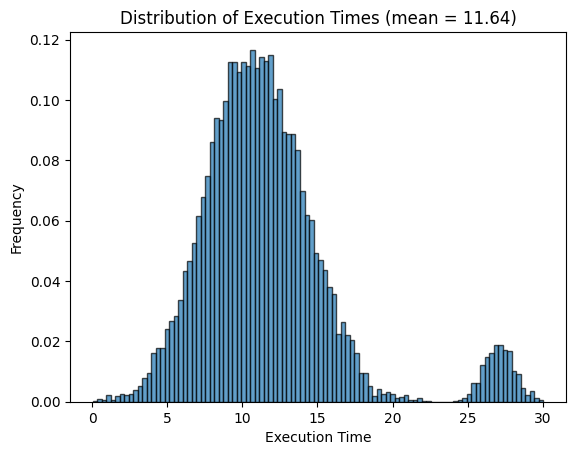

Sample Mean: 11.641962099999999
True Mean (based on expected execution time): 11.667445638680611
Average utilization rate (based on sample): 0.012886102400683599
Average utilization rate (based on true mean): 0.012914309285927638


In [8]:
# ==================== Tasksetクラスを使用してタスクセットを生成 ==================== #
seed = 3
task_num = 100
utilization_rate = 0.60
taskset = Taskset(task_num, utilization_rate, seed=seed)

# タイムラインサイズを出力
print(f"Timeline size: {len(taskset.timeline)}")

# タスクセットの情報を出力
print("Task Set:")
for idx, task in enumerate(taskset.tasks):
    print(f"WCET: {task.wcet}, Relative Deadline: {task.relative_deadline}, Min Inter-Arrival: {task.minimum_inter_arrival_time}")

# タイムラインの内容を最初の10個分だけ表示
print("\nTimeline:")
print_time = 0
for t, jobs_at_t in enumerate(taskset.timeline):
    if print_time > 10:
        break
    if jobs_at_t:
        print(f"Time {t}: {[f'Job Execution Time: {job.task.get_execution_time()}' for job in jobs_at_t]}")
        print_time = print_time + 1

# サンプルを取って分布を表示
sample_count = 10000
task_idx = -1 # 対象タスクのインデックス
samples = [taskset.tasks[task_idx].get_execution_time() for _ in range(sample_count)]
# samples = [taskset.tasks[task_idx].get_execution_time_with_weight()[0] for _ in range(sample_count)]

# サンプルの平均値を計算
sample_mean = np.mean(samples)

# 実行時間のヒストグラムを表示
plt.hist(
    samples,
    bins=100,
    edgecolor='black',
    alpha=0.7,
    density=True
)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.title(f'Distribution of Execution Times (mean = {sample_mean:.2f})')
plt.show()

# 真の平均を計算 (実行時間期待値を利用)
trunc_lower = 0
trunc_upper = taskset.tasks[task_idx].wcet  # 最大実行時間（WCET）を範囲の上限に設定
true_mean = calculate_expected_execution_time(
    wcet=taskset.tasks[task_idx].wcet,
    trunc_lower=trunc_lower,
    trunc_upper=trunc_upper
)

# 平均と利用率を出力
print(f"Sample Mean: {sample_mean}")
print(f"True Mean (based on expected execution time): {true_mean}")
print(f"Average utilization rate (based on sample): {sample_mean / taskset.tasks[task_idx].minimum_inter_arrival_time}")
print(f"Average utilization rate (based on true mean): {true_mean / taskset.tasks[task_idx].minimum_inter_arrival_time}")


In [9]:
# ==================== 通常サンプリングによって応答時間算出 ==================== #

def calculate_response_time(taskset, target_job, log_flag=False, traditional_ci=False):
    carry_in = 0
    boundary = 0
    total_prev_cost = 0
    arrival_times = taskset.arrival_times  # tasksetから到着時刻リストを取得
    timeline = taskset.timeline  # tasksetからタイムラインを取得

    while boundary < len(arrival_times) and arrival_times[boundary] * MINIMUM_TIME_UNIT < target_job.release_time:
        boundary += 1

    # t = 0 において、最大の Carry-in を考慮
    carry_in = target_job.task.get_execution_time()
    for job in timeline[arrival_times[0]]:
        # target_jobより優先度が低くなったら break
        if job < target_job:
            break
        carry_in += job.task.get_execution_time()

    # 従来の CI で行うなら
    if traditional_ci:
        carry_in = 0

    if log_flag:
        print(f"carry_in : {carry_in}")
        print(f"total_prev_cost : {total_prev_cost}")
        print(f"boundary : {boundary}")

    # idxから始めて arrive_times[idx] が target_job.absolute_deadline 以下の時に while ループを回す
    idx = boundary
    total_next_cost = 0
    while idx < len(arrival_times) and arrival_times[idx] * MINIMUM_TIME_UNIT <= target_job.absolute_deadline:
        # [release_time, arrival_times[idx]] の間で v_0 と時間差を確認
        for job in timeline[arrival_times[idx]]:
            if job < target_job or job == target_job:
                continue
            total_next_cost += job.task.get_execution_time()

        # コストが時間差以下ならレスポンスタイムを計算して終了
        if carry_in + total_next_cost <= arrival_times[idx] * MINIMUM_TIME_UNIT - arrival_times[boundary] * MINIMUM_TIME_UNIT:
            if log_flag:
                print("\n========== Scheduling Succeeded !! ==========\n")
            return carry_in + total_next_cost

        idx += 1  # 次の到着時刻へ

    # 最後に absolute_deadline でレスポンスがデッドラインに間に合うかを確認
    if carry_in + total_next_cost <= target_job.absolute_deadline - arrival_times[boundary] * MINIMUM_TIME_UNIT:
        if log_flag:
            print("\n========== Scheduling Succeeded !! ==========\n")
        return carry_in + total_next_cost

    # デッドラインを過ぎた場合はデッドラインに最小時間単位を加えて返す
    if log_flag:
        print("\n========== Scheduling Failed ... ==========\n")
    # return target_job.absolute_deadline + MINIMUM_TIME_UNIT
    return carry_in + total_next_cost # 切り捨て応答時間ではなく厳密な応答時間を返す場合


In [10]:
# 実際にタスクセット 1 の最低優先度のタスクのジョブのレスポンスタイムを見てみる
print(f"timeline[0][-1] absolute_deadline : {taskset.timeline[0][-1].absolute_deadline}")
print(f"timeline[0][-1] execution_time : {taskset.timeline[0][-1].task.get_execution_time()}\n")

response_time = calculate_response_time(taskset, taskset.timeline[0][-1], log_flag=True)
print(f"Calculated Response Time: {response_time}")


timeline[0][-1] absolute_deadline : 903.451
timeline[0][-1] execution_time : 11.088

carry_in : 182.097
total_prev_cost : 0
boundary : 0

========== Scheduling Succeeded !! ==========

Calculated Response Time: 672.4369999999998


In [11]:
# ==================== 重要度サンプリングによって応答時間算出 & 重み計算 ==================== #

def calculate_response_time_with_weight(taskset, target_job, log_flag=False, traditional_ci=False):
    carry_in = 0
    boundary = 0
    total_prev_cost = 0
    arrival_times = taskset.arrival_times  # tasksetから到着時刻リストを取得
    timeline = taskset.timeline  # tasksetからタイムラインを取得
    log_weight_sum = 0  # 対数重みの合計

    while boundary < len(arrival_times) and arrival_times[boundary] * MINIMUM_TIME_UNIT < target_job.release_time:
        boundary += 1

    # t = 0 において、最大の Carry-in を考慮
    carry_in = target_job.task.get_execution_time_with_weight()[0]
    for job in timeline[arrival_times[0]]:
        # target_jobより優先度が低くなったら break
        if job < target_job:
            break
        execution_time, weight = job.task.get_execution_time_with_weight()
        carry_in += execution_time
        log_weight_sum += np.log(weight)

    # 従来の CI で行うなら
    if traditional_ci:
        carry_in = 0

    if log_flag:
        print(f"carry_in : {carry_in}")
        print(f"total_prev_cost : {total_prev_cost}")
        print(f"boundary : {boundary}")

    # idxから始めて arrive_times[idx] が target_job.absolute_deadline 以下の時に while ループを回す
    idx = boundary
    total_next_cost = 0
    while idx < len(arrival_times) and arrival_times[idx] * MINIMUM_TIME_UNIT <= target_job.absolute_deadline:
        # [release_time, arrival_times[idx]] の間で v_0 と時間差を確認
        for job in timeline[arrival_times[idx]]:
            if job < target_job or job == target_job:
                continue
            execution_time, weight = job.task.get_execution_time_with_weight()
            total_next_cost += execution_time
            log_weight_sum += np.log(weight)

        # コストが時間差以下ならレスポンスタイムを計算して終了
        if carry_in + total_next_cost <= arrival_times[idx] * MINIMUM_TIME_UNIT - arrival_times[boundary] * MINIMUM_TIME_UNIT:
            if log_flag:
                print("\n========== Scheduling Succeeded !! ==========\n")
            total_weight = np.exp(log_weight_sum)
            return carry_in + total_next_cost, total_weight

        idx += 1  # 次の到着時刻へ

    # 最後に absolute_deadline でレスポンスがデッドラインに間に合うかを確認
    if carry_in + total_next_cost <= target_job.absolute_deadline - arrival_times[boundary] * MINIMUM_TIME_UNIT:
        if log_flag:
            print("\n========== Scheduling Succeeded !! ==========\n")
        total_weight = np.exp(log_weight_sum)
        return carry_in + total_next_cost, total_weight

    # デッドラインを過ぎた場合はデッドラインに最小時間単位を加えて返す
    if log_flag:
        print("\n========== Scheduling Failed ... ==========\n")
    total_weight = np.exp(log_weight_sum)
    return carry_in + total_next_cost, total_weight



In [12]:
# 実際にタスクセット 1 の最低優先度のタスクのジョブのレスポンスタイムと重みを計算
print(f"timeline[0][-1] absolute_deadline : {taskset.timeline[0][-1].absolute_deadline}")
print(f"timeline[0][-1] execution_time : {taskset.timeline[0][-1].task.get_execution_time()}\n")

# calculate_response_time_with_weight を実行
response_time, weight = calculate_response_time_with_weight(taskset, taskset.timeline[0][-1], log_flag=True)
print(f"Calculated Response Time: {response_time}")
print(f"Weight: {weight:.20f}")


timeline[0][-1] absolute_deadline : 903.451
timeline[0][-1] execution_time : 8.133

carry_in : 178.45800000000003
total_prev_cost : 0
boundary : 0

========== Scheduling Succeeded !! ==========

Calculated Response Time: 627.7759999999996
Weight: 1.07783414894187856703


In [13]:
# ==================== 様々な信頼区間で WCDFP を求められるような基盤整理 ==================== #

# サンプルサイズを計算する関数 (正規分布近似を利用した算出方法)
def required_sample_size_binomial(error_margin, false_probability):
    z = norm.ppf(1 - (false_probability / 2))  # z-score (信頼区間)
    p = 0.5  # デッドラインミス確率の最大不確定性 (最悪の場合)
    required_n = (z**2 * p * (1 - p)) / (error_margin**2)

    print(f"z値 : {z}")
    print(f"required_n : {np.ceil(required_n)}")
    
    return np.ceil(required_n)

# prepare_sample ケースで WCDFP の上限を算出し、それを用いて必要 sample 数を算出する方法
def required_sample_size_binomial_with_estimation(taskset, error_margin, false_probability, samples=1000):
    # 初期の探索範囲を設定
    n_min = 1
    n_max = 1e10  # 適切な上限値を設定してください
    required_n = None
    _, success_p = calculate_response_time_distribution(
        taskset,
        taskset.timeline[0][-1],
        false_probability=false_probability,
        log_flag=False,
        traditional_ci=False,
        plot_flag=False,
        thread_num=1,
        samples=samples
    )

    while n_min <= n_max:
        n_mid = (n_min + n_max) // 2

        a = int(n_mid * success_p) + 0.5  # s + 0.5, s = 0
        b = (n_mid - int(n_mid * success_p)) + 0.5  # n - s + 0.5, s = 0

        # 信頼区間の下限と上限を計算
        lower = beta.ppf(false_probability / 2, a, b)
        upper = beta.ppf(1 - false_probability / 2, a, b)
        width = upper - lower

        # 信頼区間の幅が ε 以下かを確認
        if width <= error_margin:
            required_n = n_mid
            n_max = n_mid - 1  # より小さい n を探索
        else:
            n_min = n_mid + 1  # より大きい n を探索
    
    print(f"required_n : {np.ceil(required_n)}")
    return required_n

# アグレッシブクール法を用いたデッドラインミス確率の上限を計算する関数
def calculate_deadline_miss_probability_agresti_coull(deadline_miss_cnt, total_samples, false_probability):
    z = norm.ppf(1 - (false_probability / 2))  # z-score (信頼区間)

    # アグレッシブクール法による修正
    s_tilde = total_samples + z**2
    p_tilde = (deadline_miss_cnt + z**2 / 2) / s_tilde

    # 信頼区間の上限を計算
    upper_bound = p_tilde + z * np.sqrt(p_tilde * (1 - p_tilde) / s_tilde)

    return upper_bound

def calculate_deadline_miss_probability_jeffreys(deadline_miss_cnt, total_samples, false_probability):
    # ベータ分布に基づいて上限を計算
    upper_bound = beta.ppf(1 - false_probability / 2, deadline_miss_cnt + 0.5, total_samples - deadline_miss_cnt + 0.5)

    return upper_bound

def sample_responses(n_samples, taskset, target_job, seed):
    # スレッドごとに個別のシードを設定
    np.random.seed(seed)

    sub_response_times = []
    sub_deadline_miss_cnt = 0

    for _ in range(n_samples):
        response_time = calculate_response_time(taskset, target_job)
        sub_response_times.append(response_time)
        if response_time >= target_job.absolute_deadline:
            sub_deadline_miss_cnt += 1
    return sub_response_times, sub_deadline_miss_cnt

def sample_responses_with_weight(taskset, target_job, num_samples, seed=0):
    np.random.seed(seed)

    response_time_slices = []
    weight_sums = []

    for _ in range(num_samples):
        response_time, weight = calculate_response_time_with_weight(taskset, target_job)
        response_time_slices.append(response_time)
        weight_sums.append(weight)

    # 応答時間と重みを返す
    return response_time_slices, weight_sums

def calculate_response_time_distribution(taskset, target_job, false_probability=0.000001,
                                         log_flag=False, traditional_ci=False, plot_flag=False, seed=0, thread_num=1, samples=0):
    np.random.seed(seed)

    # レスポンスタイムを保存するリスト
    response_times = []
    # デッドラインミス回数のカウンタを初期化
    deadline_miss_cnt = 0

    # 各スレッドのサンプリング数を計算
    samples_per_thread = int(samples // thread_num)

    if thread_num == 1:
        # シングルスレッドで処理
        for _ in tqdm(range(int(samples)), desc="Collecting Samples"):
            response_time = calculate_response_time(taskset, target_job)
            response_times.append(response_time)
            if response_time >= target_job.absolute_deadline:
                deadline_miss_cnt += 1
    else:
        # 並列処理の実行
        samples_per_thread = int(samples // thread_num)
        with ProcessPoolExecutor(max_workers=thread_num) as executor:
            futures = []
            for i in range(thread_num):
                n_samples = samples_per_thread + (1 if i < int(samples % thread_num) else 0)
                thread_seed = seed + i
                futures.append(executor.submit(sample_responses, n_samples, taskset, target_job, thread_seed))

            for future in tqdm(futures, desc="Collecting Results from Processes"):
                sub_response_times, sub_deadline_miss_cnt = future.result()
                if plot_flag:
                  response_times.extend(sub_response_times)
                deadline_miss_cnt += sub_deadline_miss_cnt

    # デッドラインミス確率の上限を計算 (アグレッシティークール区間)
    deadline_miss_prob_upper_agresti_coull = calculate_deadline_miss_probability_agresti_coull(
        deadline_miss_cnt, samples, false_probability
    )

    # デッドラインミス確率の上限を計算 (ジェフリーズ区間)
    deadline_miss_prob_upper_jeffreys = calculate_deadline_miss_probability_jeffreys(
        deadline_miss_cnt, samples, false_probability
    )

    # ログ出力
    if log_flag:
        print("【WCDFP (agresti_coull) 】:", deadline_miss_prob_upper_agresti_coull)
        print("【WCDFP (jeffreys) 】:", deadline_miss_prob_upper_jeffreys)

        # デッドライン超過回数を表示
        print(f"deadline_miss_cnt: {deadline_miss_cnt}")
        print(f"DFP: {deadline_miss_cnt / samples}")
        print(f"len(response_time) : {len(response_times)}")

    # plot_flag が True の場合にのみヒストグラムをプロット
    if plot_flag:
        plt.figure(figsize=(10, 6))
        plt.hist(response_times, bins=100, color='blue', alpha=0.7)
        plt.title(f"Response Time Distribution (Sampled {int(samples)} times)")
        plt.xlabel("Response Time")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    return response_times, deadline_miss_prob_upper_jeffreys

def calculate_response_time_distribution_with_normal_ci(
    taskset, target_job, false_probability=0.000001,
    log_flag=False, plot_flag=False, seed=0, thread_num=1, samples=0
):
    # 正規分布近似の信頼区間を用いて重要度サンプリングを用いた推定を行う関数
    np.random.seed(seed)

    # 応答時間と重みを保存するリスト
    response_times = []
    weights = []

    # 各スレッドのサンプリング数を計算
    samples_per_thread = int(samples // thread_num)

    if thread_num == 1:
        # シングルスレッドで処理
        for _ in tqdm(range(int(samples)), desc="Collecting Samples"):
            response_time, weight = calculate_response_time_with_weight(taskset, target_job, log_flag=log_flag)
            response_times.append(response_time)
            weights.append(weight)
    else:
        # 並列処理の実行
        samples_per_thread = int(samples // thread_num)
        with ProcessPoolExecutor(max_workers=thread_num) as executor:
            futures = []
            for i in range(thread_num):
                n_samples = samples_per_thread + (1 if i < int(samples % thread_num) else 0)
                thread_seed = seed + i
                futures.append(executor.submit(
                    sample_responses_with_weight, taskset, target_job, n_samples, thread_seed
                ))

            for future in tqdm(futures, desc="Collecting Results from Processes"):
                sub_response_times, sub_weights = future.result()
                response_times.extend(sub_response_times)
                weights.extend(sub_weights)

    # デッドラインミス確率の計算
    deadline_miss_cnt = sum(1 for rt in response_times if rt >= target_job.absolute_deadline)
    weighted_deadline_miss_cnt = sum(
        w for rt, w in zip(response_times, weights) if rt >= target_job.absolute_deadline
    )
    total_weight = sum(weights)
    p_hat = weighted_deadline_miss_cnt / total_weight

    # 正規分布近似による信頼区間
    variance = sum(w**2 * ((1 if rt >= target_job.absolute_deadline else 0) - p_hat)**2 for rt, w in zip(response_times, weights)) / total_weight**2
    z_alpha = -np.log(false_probability)  # 1 - α 水準に対応する z 値
    ci_upper = p_hat + z_alpha * np.sqrt(variance)

    # ログ出力
    if log_flag:
        # weights を NumPy 配列に変換
        weights_array = np.array(weights)

        # ESS (Effective Sample Size) を計算
        sum_weights = np.sum(weights_array)
        sum_weights_squared = np.sum(weights_array ** 2)
        ess = (sum_weights ** 2) / sum_weights_squared

        # 出力
        print("【WCDFP (Normal Approximation) 】:", ci_upper)
        print(f"Weighted DFP: {p_hat}")
        print(f"Total Weighted Samples: {total_weight}")
        print(f"Deadline Miss Count: {deadline_miss_cnt}")
        print(f"len(response_time): {len(response_times)}")
        print(f"Effective Sample Size (ESS): {ess:.2f}")


    # plot_flag が True の場合にのみヒストグラムをプロット
    if plot_flag:
        plt.figure(figsize=(10, 6))
        plt.hist(response_times, bins=100, color='blue', alpha=0.7)
        plt.title(f"Response Time Distribution (Sampled {int(samples)} times)")
        plt.xlabel("Response Time")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    return response_times, ci_upper


In [14]:
# ==================== Berry-Essen によるデッドラインミス確率推定手法を検証 =================== #

# Berry-Essenの累積分布関数とペナルティ項ψを計算してプロットする関数
def calculate_berry_essen_cdf(taskset, target_job, A=1.0, upper=True):
    """
    taskset の各タスクが解析対象ジョブの絶対デッドラインまでにリリースされる回数を αとして計算し、Berry-Essenの定理に基づく累積分布関数を求める関数
    upper が True の場合、上限を、False の場合、下限を返す
    """
    absolute_deadline = target_job.absolute_deadline  # 解析対象ジョブの絶対デッドライン
    rho_sum = 0   # ρ_i の合計
    alpha_sigma_sum = 0  # α_i^2 * V[C_i] の合計
    mu_sum = 0  # α_i,t * E[C_i] の合計
    max_sum = 0  # 各タスクの α_i,t * max(I(C_i)) の合計

    # 各タスクに対して、絶対デッドラインまでにリリースされる回数（α）を計算
    for task in taskset.tasks:
        alpha_i_t = np.ceil((absolute_deadline + task.relative_deadline) / task.minimum_inter_arrival_time)

        # 正常時と異常時の分布パラメータ
        normal_mu = task.normal_mu      # 正常時の期待値
        abnormal_mu = task.abnormal_mu  # 異常時の期待値
        normal_sigma = task.normal_sigma  # 正常時の標準偏差
        abnormal_sigma = task.abnormal_sigma  # 異常時の標準偏差

        # 真の実行時間分布の期待値と分散
        expected_mu = (1 - ABNORMAL_MODE_PROB) * normal_mu + ABNORMAL_MODE_PROB * abnormal_mu
        expected_variance = (1 - ABNORMAL_MODE_PROB) * normal_sigma**2 + \
                            ABNORMAL_MODE_PROB * abnormal_sigma**2 + \
                            (1 - ABNORMAL_MODE_PROB) * (normal_mu - expected_mu)**2 + \
                            ABNORMAL_MODE_PROB * (abnormal_mu - expected_mu)**2

        # μ (平均) の計算
        mu_sum += alpha_i_t * expected_mu

        # α_i^2 * V[C_i] (分散部分) の計算
        alpha_sigma_sum += alpha_i_t**2 * expected_variance

        # max(I(C_i)) の計算
        max_sum += alpha_i_t * task.wcet

        # ρ_i の計算 (α_i,t * |C_i - E[C_i]|^3)
        execution_time_samples = np.array([task.get_execution_time() for _ in range(1000)])  # サンプルを取得
        rho_i = alpha_i_t * np.mean(np.abs(execution_time_samples - expected_mu)**3)
        rho_sum += rho_i

    # σ（標準偏差）の計算
    sigma_total = np.sqrt(alpha_sigma_sum)

    # ペナルティ項 ψ の計算
    psi = (sigma_total**(-3)) * rho_sum

    # 累積分布関数を生成
    x_values = np.linspace(mu_sum - 4 * sigma_total, mu_sum + 4 * sigma_total, 1000)  # 範囲設定

    # 上限（upper=True）の場合は -Aψ, 下限（upper=False）の場合は +Aψ を使用
    if upper:
        berry_essen_cdf_values = norm.cdf((x_values - mu_sum) / sigma_total) - A * psi  # 標準正規分布 - A * ペナルティ項
    else:
        berry_essen_cdf_values = norm.cdf((x_values - mu_sum) / sigma_total) + A * psi  # 標準正規分布 + A * ペナルティ項

    # Z(x) を 0 と 1 の間に制限
    berry_essen_cdf_values = np.clip(berry_essen_cdf_values, 0, 1)

    # x ≥ max_sum の場合、Z(x) = 1 とする
    berry_essen_cdf_values[x_values >= max_sum] = 1

    return x_values, berry_essen_cdf_values


In [15]:
def compute_pessimism_cost(start, end, boundary_value, execution_times, probabilities):
    cost = 0
    for i in range(start, end):
        cost += probabilities[i] * abs(execution_times[i] - boundary_value)
    return cost

def optimal_downsampling(probabilities, max_boundaries):
    # 確率密度関数をダウンサンプリングして返す関数
    execution_times = np.array([0] + [ele.item() for ele in np.nonzero(probabilities)[0]])

    n = len(execution_times)
    # DP 配列を初期化 (i: 現在の位置, j: 使用した境界数)
    dp = np.full((n + 1, max_boundaries + 1), float('inf'))
    trace = np.full((n + 1, max_boundaries + 1), -1, dtype=int)  # 経路追跡用
    dp[0][0] = 0
    for i in range(1, n + 1):
        for j in range(1, max_boundaries + 1):
            for k in range(i):
                cost = compute_pessimism_cost(k, i, execution_times[i - 1], execution_times, probabilities)
                if dp[i][j] > dp[k][j - 1] + cost:
                    dp[i][j] = dp[k][j - 1] + cost
                    trace[i][j] = k

    # 経路追跡
    boundaries = []
    current_i = n
    current_j = max_boundaries
    while current_j > 0:
        boundaries.append(execution_times[current_i - 1])
        current_i = trace[current_i][current_j]
        current_j -= 1
    boundaries.append(0)
    boundaries.reverse()

    # 新しい確率密度関数を計算
    new_probabilities = np.zeros_like(probabilities)
    for i in range(1, len(boundaries)):
        mask = (execution_times > boundaries[i - 1]) & (execution_times <= boundaries[i])
        new_probabilities[boundaries[i]] = np.sum(probabilities[mask])
    print("\n")
    return new_probabilities

def convolve(pdf1, pdf2):
    convolved_pdf = fftconvolve(pdf1, pdf2, mode='full')
    truncated_pdf = np.maximum(convolved_pdf, 0.0)
    return truncated_pdf

def convolve_and_truncate(pdf1, pdf2, size):
    convolved_pdf = fftconvolve(pdf1, pdf2, mode='full')
    truncated_pdf = np.maximum(convolved_pdf, 0.0)
    exceed_prob = np.sum(truncated_pdf[size:])
    truncated_pdf = truncated_pdf[:size]
    # exceed_prob が負の場合は error
    if exceed_prob < 0:
        raise ValueError("Exceed probability is negative.")
    # truncated_pdf /= np.sum(truncated_pdf) # 確率密度関数に変更するように正規化
    return truncated_pdf, exceed_prob

# ================= ここから実際に応答時間シミュ ================ #

def calculate_response_time_by_conv(taskset, target_job, log_flag=False, traditional_ci=False):
    boundary = 0
    arrival_times = taskset.arrival_times  # tasksetから到着時刻リストを取得
    timeline = taskset.timeline  # tasksetからタイムラインを取得

    response_time = [1.0]
    wcdfp = 1.0
    size = int(target_job.absolute_deadline / MINIMUM_TIME_UNIT) + 1

    while boundary < len(arrival_times) and arrival_times[boundary] * MINIMUM_TIME_UNIT < target_job.release_time:
        boundary += 1

    # Carry-in 考慮
    carry_in = target_job.task.get_execution_time_with_weight()[0]
    for job in timeline[arrival_times[0]]:
        # target_jobより優先度が低くなったら break
        if job < target_job:
            break
        # response_time, exceed = convolve_and_truncate(
        #     response_time,
        #     job.task.original_pdf_values / np.sum(job.task.original_pdf_values),
        #     size=size
        # )
        # wcdfp -= exceed
        response_time = convolve(
            response_time,
            job.task.original_pdf_values / np.sum(job.task.original_pdf_values),
        )

    # 従来の CI で行うなら
    if traditional_ci:
        carry_in = 0

    if log_flag:
        print(f"carry_in : {carry_in}")
        print(f"boundary : {boundary}")

    idx = boundary
    true_response_time = np.zeros(size)

    progress_bar = tqdm(total=len(arrival_times), desc="Processing arrival times", unit="step", dynamic_ncols=True, leave=True, position=0, file=sys.stdout)
    while idx < len(arrival_times) and arrival_times[idx] * MINIMUM_TIME_UNIT <= target_job.absolute_deadline:
        # 間に合ってるケースはもう固定して以降の計算で出ないようにする
        for i in range(0 if idx == 0 else arrival_times[idx - 1], arrival_times[idx]):
            true_response_time[i] += response_time[i]
            response_time[i] = 0.0

        for job in timeline[arrival_times[idx]]:
            if job < target_job or job == target_job:
                continue
            # response_time, exceed = convolve_and_truncate(
            #     response_time,
            #     job.task.original_pdf_values / np.sum(job.task.original_pdf_values),
            #     size=size
            # )
            # wcdfp -= exceed
            response_time = convolve(
                response_time,
                job.task.original_pdf_values / np.sum(job.task.original_pdf_values),
            )
    
        # tqdm の進捗を更新
        progress_bar.update(1)
        idx += 1  # 次の到着時刻へ

    progress_bar.close()  # プログレスバーを閉じる
    
    for i in range(len(true_response_time)):
        response_time[i] += true_response_time[i]
    
    wcdfp = np.sum(response_time[size:])
    print(f"np.sum(response_time) : {np.sum(response_time)}")
    print(f"WCDFP : {wcdfp}")
    return response_time

def compute_response_time_with_doubling(taskset, target_job):
    response_time = np.array([1.0])  # 初期分布
    wcdfp = 1.0
    size = int(target_job.absolute_deadline / MINIMUM_TIME_UNIT) + 1

    # タスクセット内の各タスクに対して処理を実行
    for task in tqdm(taskset.tasks, desc="Processing tasks", unit="task"):
        # そのタスクのリリース回数を計算
        release_count = int(np.ceil((target_job.task.relative_deadline + task.relative_deadline) / task.minimum_inter_arrival_time))
        if target_job.task == task:
            release_count = 1
        # print(f"task.relative_deadline : {task.relative_deadline}")
        # print(f"release_count : {release_count}")

        # タスクの実行時間分布を正規化
        normalized_pdf = task.original_pdf_values / np.sum(task.original_pdf_values)

        # ダブリングで畳み込み
        current_pdf = normalized_pdf
        while release_count > 0:
            if release_count % 2 == 1:
                # response_time, exceed = convolve_and_truncate(
                #     response_time,
                #     current_pdf,
                #     size=size
                # )
                # wcdfp -= exceed
                response_time = convolve(
                    response_time,
                    current_pdf
                )
            # current_pdf, _ = convolve_and_truncate(
            #     current_pdf,
            #     current_pdf,
            #     size=size
            # )
            current_pdf = convolve(
                current_pdf,
                current_pdf
            )
            current_pdf /= np.sum(current_pdf)  # 正規化
            response_time /= np.sum(response_time)  # 正規化
            release_count //= 2

    wcdfp = np.sum(response_time[size:])
    print(f"np.sum(response_time) : {np.sum(response_time)}")
    print(f"WCDFP : {wcdfp}")
    return response_time

def plot_response_time_distribution(response_time, time_unit=MINIMUM_TIME_UNIT):
    time_indices = np.arange(len(response_time)) * time_unit
    plt.figure(figsize=(10, 6))
    plt.plot(time_indices, response_time,
             drawstyle='steps-mid', label="Response Time Distribution", color="blue")
    plt.xlabel("Response Time")
    plt.ylabel("Probability Density")
    plt.title("Response Time Distribution")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


【WCDFP (agresti_coull) 】: 0.002880477959628535
【WCDFP (jeffreys) 】: 0.001262362003499779
deadline_miss_cnt: 0
DFP: 0.0
len(response_time) : 10000


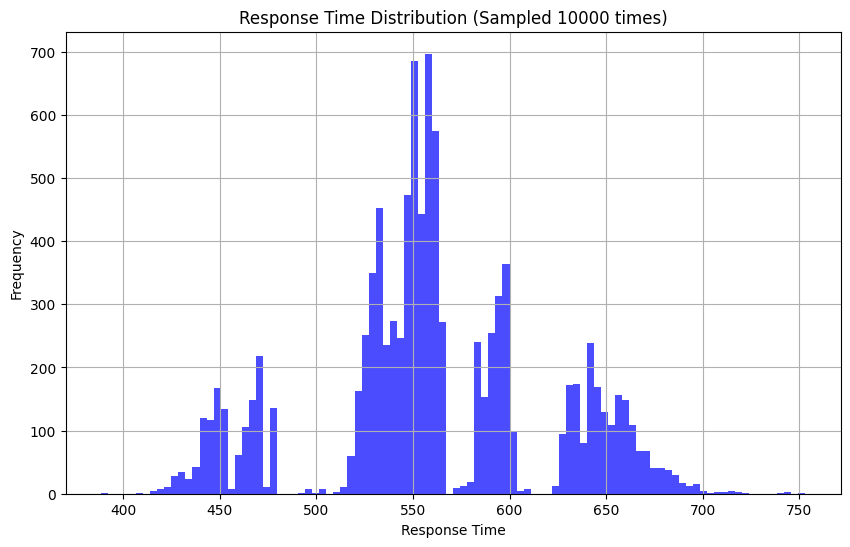

Monte Carlo WCDFP : 0.001262362003499779

Elapsed Time : 9.62 sec

carry_in : 11.968
boundary : 0
Processing arrival times: 100%|██████████| 1869/1869 [02:11<00:00, 14.25step/s]
np.sum(response_time) : 1.0000000000000846
WCDFP : 2.3241957170570257e-09
Elapsed Time : 131.55 sec



Processing tasks: 100%|██████████| 100/100 [00:08<00:00, 11.93task/s]


np.sum(response_time) : 1.0
WCDFP : 8.175027021185347e-09
Elapsed Time : 8.39 sec

Elapsed Time : 0.23 sec



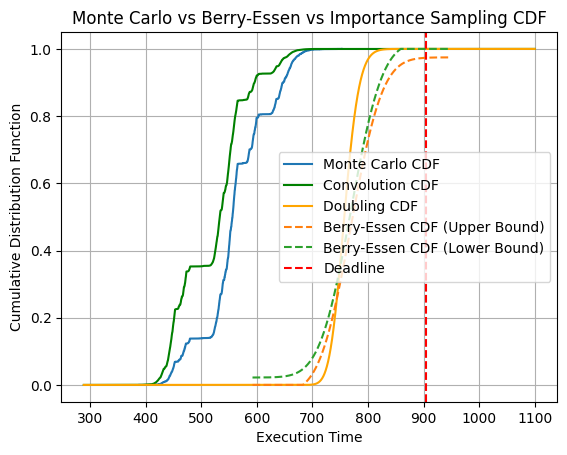

In [16]:
# ==================== MonteCalro の応答時間と、Berry-Essen の応答時間の上限を同時に plot ==================== #

start_time = time.time()

# Monte Carlo法のサンプル数を計算
error_margin = 0.01
false_probability = 0.000001
# samples = required_sample_size_binomial_with_estimation(
#     taskset,
#     error_margin=error_margin,
#     false_probability=false_probability,
#     samples=10000
# )
samples = 10000

# Monte Carlo の応答時間分布を生成 + WCDFP, CDF 計算 + plot
response_times_mc, wcdfp_mc = calculate_response_time_distribution(
    taskset,
    taskset.timeline[0][-1],
    false_probability=false_probability,
    thread_num=16,
    log_flag=True,
    plot_flag=True,
    samples=samples
)
sorted_times_mc = np.sort(response_times_mc)
monte_carlo_cdf_values = np.arange(1, len(sorted_times_mc) + 1) / len(sorted_times_mc)
print(f"Monte Carlo WCDFP : {wcdfp_mc}\n")
print(f"Elapsed Time : {time.time() - start_time:.2f} sec\n")

# # 重要度サンプリングによる応答時間分布と WCDFP を計算
# start_time = time.time()
# response_times_is, wcdfp_is = calculate_response_time_distribution_with_normal_ci(
#     taskset,
#     taskset.timeline[0][-1],
#     false_probability=false_probability,
#     thread_num=16,
#     log_flag=True,
#     plot_flag=True,
#     samples=samples
# )
# sorted_times_is = np.sort(response_times_is)
# importance_sampling_cdf_values = np.arange(1, len(sorted_times_is) + 1) / len(sorted_times_is)
# print(f"Importance Sampling WCDFP : {wcdfp_is}")
# print(f"Elapsed Time : {time.time() - start_time:.2f} sec\n")

min_time_index = int((np.min(response_times_mc) - 100) / MINIMUM_TIME_UNIT)
max_time_index = int((1100) / MINIMUM_TIME_UNIT)

# # # Convolution の応答時間分布を計算 + CDF 計算 + plot
start_time = time.time()
response_time_conv = calculate_response_time_by_conv(taskset, taskset.timeline[0][-1], log_flag=True)
print(f"Elapsed Time : {time.time() - start_time:.2f} sec\n")
# plot_response_time_distribution(response_time_conv)
conv_cdf_values = np.cumsum(response_time_conv) / np.sum(response_time_conv)
conv_time_indices = np.arange(len(response_time_conv)) * MINIMUM_TIME_UNIT
conv_time_indices = conv_time_indices[min_time_index:max_time_index]
conv_cdf_values = conv_cdf_values[min_time_index:max_time_index]

# Convolution + Doubling の応答時間分布を計算 + CDF 計算 + plot
start_time = time.time()
response_time_doubling = compute_response_time_with_doubling(taskset, taskset.timeline[0][-1])
print(f"Elapsed Time : {time.time() - start_time:.2f} sec\n")
# plot_response_time_distribution(response_time_doubling)
doubling_cdf_values = np.cumsum(response_time_doubling) / np.sum(response_time_doubling)
doubling_time_indices = np.arange(len(response_time_doubling)) * MINIMUM_TIME_UNIT
doubling_time_indices = doubling_time_indices[min_time_index:max_time_index]
doubling_cdf_values = doubling_cdf_values[min_time_index:max_time_index]

# Berry-Essen の CDF の上限と下限を計算して plot
start_time = time.time()
x_values_upper, berry_essen_cdf_upper = calculate_berry_essen_cdf(taskset, taskset.timeline[0][-1], A=0.56, upper=True)
print(f"Elapsed Time : {time.time() - start_time:.2f} sec\n")
x_values_lower, berry_essen_cdf_lower = calculate_berry_essen_cdf(taskset, taskset.timeline[0][-1], A=0.56, upper=False)

plt.step(sorted_times_mc, monte_carlo_cdf_values, label="Monte Carlo CDF", where="post")
# plt.step(sorted_times_is, importance_sampling_cdf_values, label="Importance Sampling CDF", where="post", linestyle=':')
plt.plot(conv_time_indices, conv_cdf_values, label="Convolution CDF", linestyle='-', color="green")
plt.plot(doubling_time_indices, doubling_cdf_values, label="Doubling CDF", linestyle='-', color="orange")
plt.plot(x_values_upper, berry_essen_cdf_upper, label="Berry-Essen CDF (Upper Bound)", linestyle='--')
plt.plot(x_values_lower, berry_essen_cdf_lower, label="Berry-Essen CDF (Lower Bound)", linestyle='--')

# デッドラインの直線（赤点線）を plot
deadline = taskset.timeline[0][-1].absolute_deadline
plt.axvline(x=deadline, color='red', linestyle='--', label='Deadline')

# plot 設定
plt.xlabel("Execution Time")
plt.ylabel("Cumulative Distribution Function")
plt.title("Monte Carlo vs Berry-Essen vs Importance Sampling CDF")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# ==================== Chernoff Bound にてデッドラインミス確率推定 ==================== #

def calculate_log_mgf_product(taskset, target_job, s):
    log_mgf_sum = 0.0  # MGF の対数の総和を保持する変数

    # `arrival_times` を利用して、0 から target_job の相対デッドラインまで回す
    for time in taskset.arrival_times:
        # 指定したデッドラインまでの範囲に制限
        if time * MINIMUM_TIME_UNIT >= target_job.task.relative_deadline:
            break

        # 該当時刻に存在するジョブを取得
        jobs_at_time = taskset.timeline[time]

        for job in jobs_at_time:
            # 各ジョブのタスクの対数 pWCET MGF を取得し、総和に追加
            log_task_mgf = job.task.get_log_pWCET_mgf(s)
            log_mgf_sum += log_task_mgf  # log MGF の和を更新

        # print(f"time {time} log_mgf_sum : {log_mgf_sum}")

    return log_mgf_sum

def estimate_deadline_miss_probability_fixed_s(taskset, target_job, t_deadline, s=1, traditional_ci=False):
    """
    固定された s 値を使用してデッドラインミス確率を推定する関数
    """
    # traditional_ci が True の場合と False の場合での処理を分岐
    log_mgf_sum = 0
    if not traditional_ci:
        for task in taskset.tasks:
            log_mgf_sum += task.get_log_pWCET_mgf(s)

    # 全てのジョブに対して MGF のログ和を計算
    print(f"initial log_mgf_sum : {log_mgf_sum}")
    log_mgf_sum += calculate_log_mgf_product(taskset, target_job, s)
    print(f"last log_mgf_sum : {log_mgf_sum}")

    # Chernoff の上限を計算 (対数空間のまま)
    log_deadline_miss_probability = log_mgf_sum - s * t_deadline

    # 対数空間のままの結果を元の確率空間に戻す
    deadline_miss_probability = np.exp(log_deadline_miss_probability)
    return deadline_miss_probability

# 実際にデッドラインミス確率を計算
s_value = 0.1
t_deadline = taskset.timeline[0][-1].task.relative_deadline
miss_probability = estimate_deadline_miss_probability_fixed_s(
    taskset, taskset.timeline[0][-1], t_deadline, s=s_value, traditional_ci=False
)
print(f"Estimated deadline miss probability (s={s_value}, traditional_ci=False): {miss_probability}")


initial log_mgf_sum : 16.320058283778796
last log_mgf_sum : 79.89680699689092
Estimated deadline miss probability (s=0.1, traditional_ci=False): 2.8997730110031837e-05
